In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, multiply, Reshape


In [8]:
# Function to load images from a directory
def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize each image to a consistent size
            images.append(img)
    return np.array(images)

# Function to extract patches from an image
def extract_patches(image, patch_size):
    patches = []
    height, width, _ = image.shape
    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)
    return np.array(patches)

In [11]:
# Load images from the dataset
dataset_path = 'UCMerced_LandUse/Images'
categories = os.listdir(dataset_path)
X = []
y = []

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    images = load_images_from_folder(category_path)
    for image in images:
        patches = extract_patches(image, patch_size=64)  # Adjust patch_size as needed
        X.extend(patches)
        y.extend([i] * len(patches))  # Assign a label to each patch

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

Epoch 1/10
840/840 [==============================] - 74s 87ms/step - loss: 2.6713 - accuracy: 0.1747 - val_loss: 2.3116 - val_accuracy: 0.2847
Epoch 2/10
840/840 [==============================] - 73s 87ms/step - loss: 2.0851 - accuracy: 0.3513 - val_loss: 1.9497 - val_accuracy: 0.3918
Epoch 3/10
840/840 [==============================] - 68s 81ms/step - loss: 1.8437 - accuracy: 0.4246 - val_loss: 1.7821 - val_accuracy: 0.4293
Epoch 4/10
840/840 [==============================] - 69s 82ms/step - loss: 1.6780 - accuracy: 0.4761 - val_loss: 1.6753 - val_accuracy: 0.4729
Epoch 5/10
840/840 [==============================] - 69s 82ms/step - loss: 1.5417 - accuracy: 0.5151 - val_loss: 1.6976 - val_accuracy: 0.4741
Epoch 6/10
840/840 [==============================] - 69s 82ms/step - loss: 1.4263 - accuracy: 0.5473 - val_loss: 1.6014 - val_accuracy: 0.4990
Epoch 7/10
840/840 [==============================] - 68s 81ms/step - loss: 1.3318 - accuracy: 0.5769 - val_loss: 1.6422 - val_accuracy:

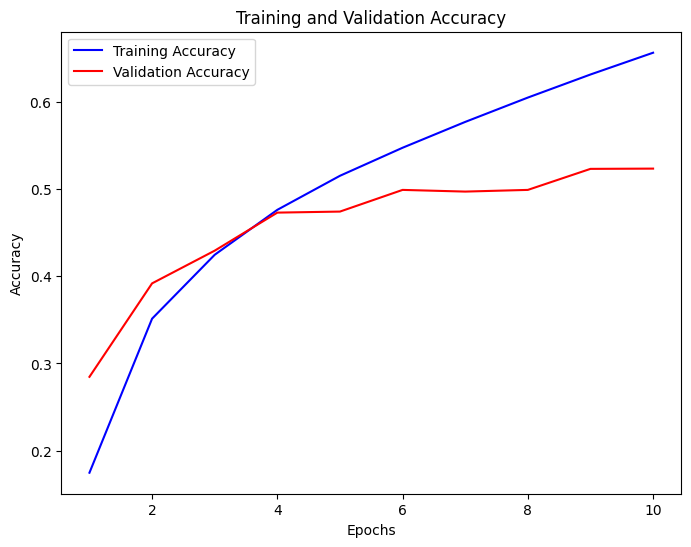

In [14]:
# Define the attention layer
def spatial_attention(input_layer):
    filters = input_layer.shape[-1]

    # Global average pooling
    avg_pool = GlobalAveragePooling2D()(input_layer)

    # Reshape to match input shape
    avg_pool = Reshape((1, 1, filters))(avg_pool)

    # Learnable parameters
    fc = Conv2D(filters, (1, 1), activation='relu')(avg_pool)

    # Element-wise multiplication
    attention = multiply([input_layer, fc])

    return attention

# Define the CNN model with attention
input_layer = Input(shape=(64, 64, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
attention1 = spatial_attention(conv1)
pool1 = MaxPooling2D((2, 2))(attention1)

conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
attention2 = spatial_attention(conv2)
pool2 = MaxPooling2D((2, 2))(attention2)

flatten = Flatten()(pool2)
dense1 = Dense(64, activation='relu')(flatten)
dense2 = Dense(len(categories), activation='softmax')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=dense2)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


# Get training and validation accuracy values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create an array of epochs
epochs = np.arange(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

210/210 [==============================] - 3s 12ms/step - loss: 2.0100 - accuracy: 0.5199
Test accuracy: 0.5199404954910278
